In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from boruta import BorutaPy
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score
import plotnine as p9
import warnings
warnings.filterwarnings("ignore")

In [3]:
df_train = pd.read_csv('housing_train.csv')
df_test = pd.read_csv('housing_test.csv')

df_test.head()
df_train_log = np.log(df_train['Sale_Price']).copy()
df_train.head()

,Lot_Frontage,Lot_Area,Year_Built,Year_Remod_Add,Mas_Vnr_Area,BsmtFin_SF_1,BsmtFin_SF_2,Bsmt_Unf_SF,First_Flr_SF,Low_Qual_Fin_SF,...,Garage_Finish_other,Paved_Drive_other,Pool_QC_other,Fence_No_Fence,Fence_other,Misc_Feature_other,Sale_Type_other,Sale_Condition_other,Gr_Liv_Area,Sale_Price
0,141,31770,1960,1960,112,2,0,441,1656,0,...,0,1,0,1,0,0,0,0,1656,215000
1,80,11622,1961,1961,0,6,144,270,896,0,...,0,0,0,0,0,0,0,0,896,105000
2,81,14267,1958,1958,108,1,0,406,1329,0,...,0,0,0,1,0,1,0,0,1329,172000
3,78,9978,1998,1998,20,3,0,324,926,0,...,0,0,0,1,0,0,0,0,1604,195500
4,41,4920,2001,2001,0,3,0,722,1338,0,...,0,0,0,1,0,0,0,0,1338,213500


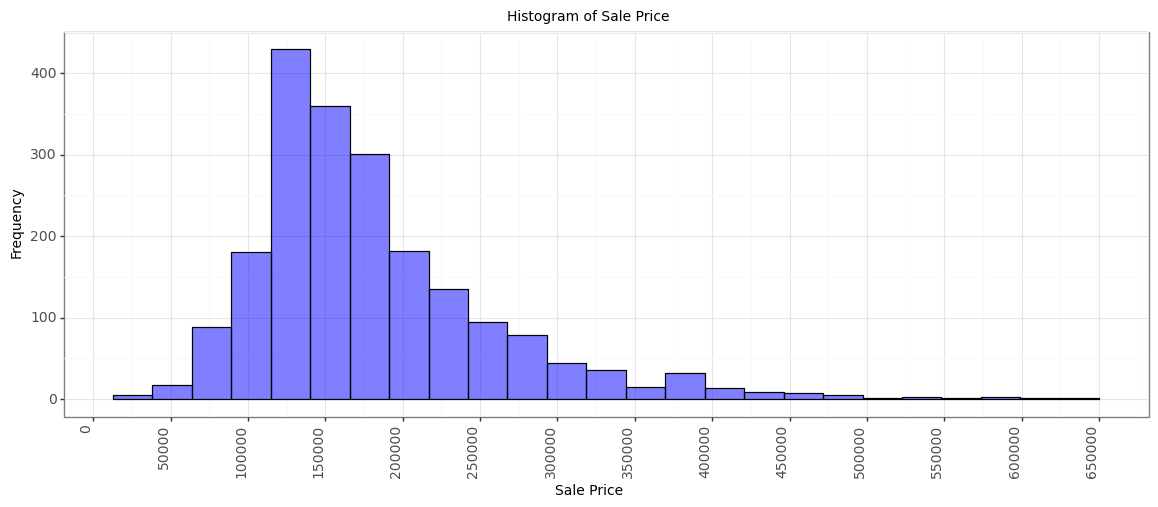

<ggplot: (375654331)>

In [4]:
p1 = p9.ggplot(df_train, p9.aes(x='Sale_Price')) + p9.geom_histogram(bins=25, fill='blue', color='black', alpha=0.5) + p9.theme_bw() + p9.theme(figure_size=(14, 5),text=p9.element_text(size=10),axis_text_x=p9.element_text(angle=90, hjust=1)) + p9.xlab('Sale Price') + p9.ylab('Frequency') + p9.ggtitle('Histogram of Sale Price')  + p9.scale_x_continuous(breaks=range(0, 800000, 50000))      
p1

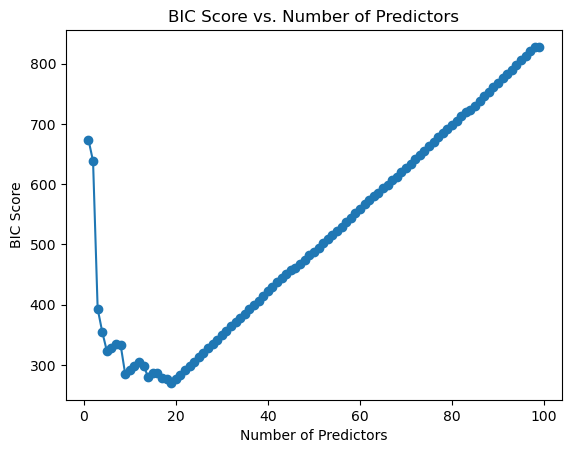

Number of variables selected by BIC: 19


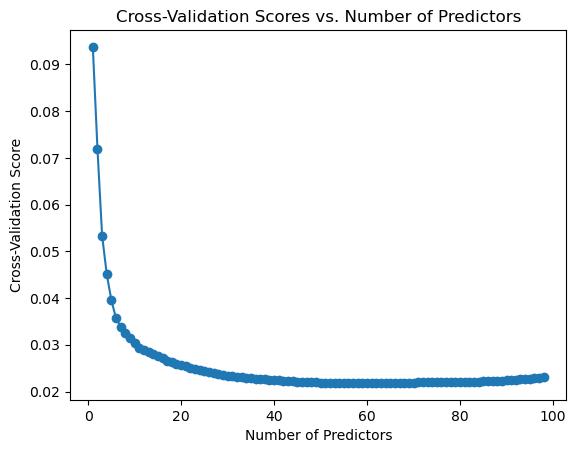

Number of variables selected by Cross-Validation: 60


In [5]:
df = df_train.copy()
df['Sale_Price'] = np.log(df['Sale_Price'])

# Calculate BIC scores
X = df.iloc[:, :99]
y = df.iloc[:, 99]

reg = LinearRegression()
kf = KFold(n_splits=10)
bic_scores = []

for num_predictors in range(1, 100):
    X_subset = X.iloc[:, :num_predictors]
    
    log_likelihood = -np.sum((y - reg.fit(X_subset, y).predict(X_subset))**2)
    bic = -2 * log_likelihood + num_predictors * np.log(len(y))
    bic_scores.append(bic)

plt.plot(range(1, 100), bic_scores, marker='o')
plt.xlabel('Number of Predictors')
plt.ylabel('BIC Score')
plt.title('BIC Score vs. Number of Predictors')
plt.show()

best_num_predictors_bic = np.argmin(bic_scores) + 1
print('Number of variables selected by BIC:', best_num_predictors_bic)

X = df_train.iloc[:, :-2].values
y = np.log(df_train.iloc[:, -1].values)

selected_features = []
remaining_features = list(range(X.shape[1]))
cv_scores = []

while remaining_features:
    scores_with_candidates = []
    for candidate in remaining_features:
        feature_set = selected_features + [candidate]
        X_train = X[:, feature_set]
        
        reg = LinearRegression()
        cv = np.mean(-cross_val_score(reg, X_train, y, cv=5, scoring="neg_mean_squared_error"))
        scores_with_candidates.append((cv, candidate))
        
    scores_with_candidates.sort()
    best_candidate = scores_with_candidates[0][1]
    selected_features.append(best_candidate)
    remaining_features.remove(best_candidate)
    cv_scores.append(scores_with_candidates[0][0])
    
plt.plot(range(1, len(cv_scores) + 1), cv_scores, marker='o')
plt.xlabel('Number of Predictors')
plt.ylabel('Cross-Validation Score')
plt.title('Cross-Validation Scores vs. Number of Predictors')
plt.show()

print('Number of variables selected by Cross-Validation:', cv_scores.index(min(cv_scores))+1)


In [6]:
reg = LinearRegression()
reg.fit(X, y)

sd = np.std(reg.coef_)
selected_features = [i for i, coef in enumerate(reg.coef_) if np.abs(coef) > sd]
X_train = X[:, selected_features]
cv = np.mean(-cross_val_score(reg, X_train, y, cv=5, scoring="neg_mean_squared_error"))

print('Number of variables selected by 1-SD Rule:', len(selected_features))

Number of variables selected by 1-SD Rule: 7


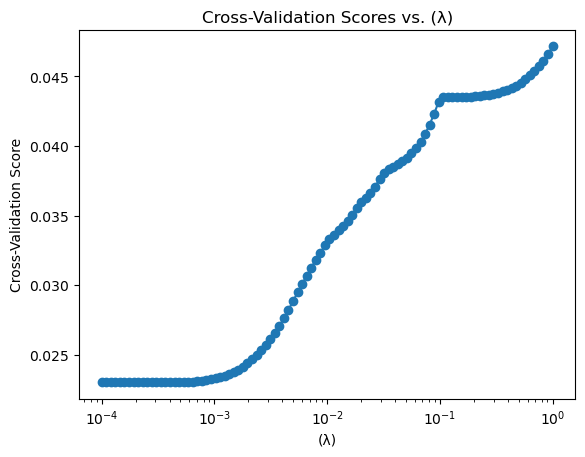

Number of variables selected by Cross-Validation: 87


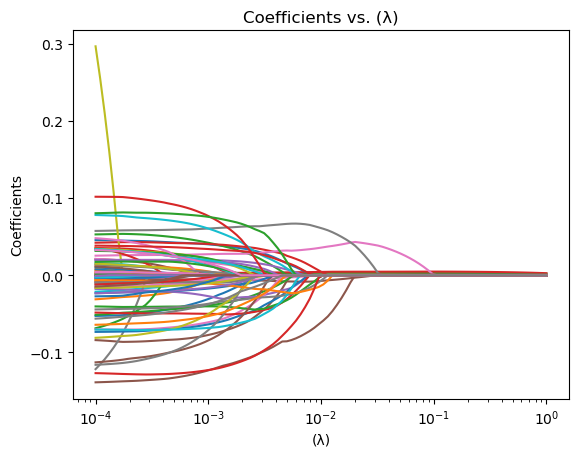

Number of variables selected by 1-SD Rule: 18


In [7]:
df = df_train.copy()
df['Sale_Price'] = np.log(df['Sale_Price'])

X = df_train.iloc[:, :-2].values
y = np.log(df_train.iloc[:, -1].values)

lasso = Lasso(fit_intercept=True)
kf = KFold(n_splits=10)

cv_scores = []
alphas = np.logspace(-4, 0, num=100)

for alpha in alphas:
    lasso.alpha = alpha
    cv_scores.append(np.mean(-cross_val_score(lasso, X, y, cv=kf, scoring="neg_mean_squared_error")))

plt.plot(alphas, cv_scores, marker='o')
plt.xscale("log")
plt.xlabel('(λ)')
plt.ylabel('Cross-Validation Score')
plt.title('Cross-Validation Scores vs. (λ)')
plt.show()

best_alpha = alphas[np.argmin(cv_scores)]
lasso.alpha = best_alpha
lasso.fit(X, y)
num_selected_by_cv = np.sum(lasso.coef_ != 0)
print('Number of variables selected by Cross-Validation:', num_selected_by_cv)

coefs = []
for alpha in alphas:
    lasso.alpha = alpha
    lasso.fit(X, y)
    coefs.append(lasso.coef_)

plt.plot(alphas, coefs)
plt.xscale("log")
plt.xlabel('(λ)')
plt.ylabel('Coefficients')
plt.title('Coefficients vs. (λ)')
plt.show()

mean = np.mean(coefs, axis=0)
std = np.std(coefs, axis=0)
num_selected_by_1sd = np.sum(np.abs(mean) > std)
print('Number of variables selected by 1-SD Rule:', num_selected_by_1sd)


# Strategy Testing

In [9]:
df_train = pd.read_csv('housing_train.csv')
df_test = pd.read_csv('housing_test.csv')

df_test.head()
df_train['Sale_Price'] = np.log(df_train['Sale_Price'])
df = df_train.copy()

### Normalize the data by handling major outliers

In [10]:
df = df_train.copy()

for i in range(99):
    if len(df[df.columns[i]].unique()) > 10:
        df_tmp = pd.DataFrame(data={'Z-Score': (df[df.columns[i]] - df[df.columns[i]].mean()) / df[df.columns[i]].std()})

        outliers = df_tmp[df_tmp['Z-Score'] > 10].index

        for j in outliers:
            df.at[j, df.columns[i]] = df[df.columns[i]].mean() + 10 * df[df.columns[i]].std()


### Check if there are variables that are almosts not correlated with price

In [11]:
corr = df.corr()[df.columns[-1]]
corr = corr.abs().sort_values()
least_predictive = corr[:20].index

df_corr = pd.DataFrame({"Variable": least_predictive, "Correlation": corr[:20].values})
df_corr

# Kick out the worst ones
corr = df.corr()[df.columns[-1]]

corr_filtered = corr[corr.abs() > 0.05]
corr_filtered_out = corr[corr.abs() < 0.05]

keep_vars = corr_filtered.index

df = df[keep_vars]

df_test = df_test[keep_vars[0:-1]]
print('We get rid of the followinig variables: ',corr_filtered_out)

We get rid of the followinig variables:  BsmtFin_SF_2             0.015585
Low_Qual_Fin_SF         -0.045317
Bsmt_Half_Bath          -0.029952
Misc_Val                -0.022021
Mo_Sold                  0.031952
Year_Sold               -0.010675
MS_Zoning_other          0.001415
Land_Contour_other       0.047495
Land_Slope_other         0.046679
Condition_2_other        0.017977
House_Style_One_Story   -0.008414
Roof_Style_other        -0.032385
Pool_QC_other            0.037329
Name: Sale_Price, dtype: float64


### Check if there are any variables that are highly correlated to each other

In [12]:
cols_in_df = set(df.columns)
cols_in_df_test = set(df_test.columns)

cols_not_in_df_test = cols_in_df - cols_in_df_test

print(f"Columns in df but not in df_test: {cols_not_in_df_test}")


Columns in df but not in df_test: {'Sale_Price'}


In [13]:
corr_matrix = df.corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

# Get the 10 highest correlations
high_corr = (upper.stack().sort_values(ascending=False).to_frame('correlation').reset_index().rename(columns={'level_0': 'feature_1', 'level_1': 'feature_2'}))[:10]
print(high_corr)


            feature_1             feature_2  correlation
0       TotRms_AbvGrd           Gr_Liv_Area     0.811637
1         Gr_Liv_Area            Sale_Price     0.712178
2    Bsmt_Exposure_No   Bsmt_Exposure_other     0.701585
3  Exter_Qual_Typical  Kitchen_Qual_Typical     0.676143
4       Bedroom_AbvGr         TotRms_AbvGrd     0.664224
5         Garage_Area            Sale_Price     0.664221
6        First_Flr_SF            Sale_Price     0.638792
7           Full_Bath           Gr_Liv_Area     0.631618
8          Year_Built     Bsmt_Qual_Typical     0.620110
9          Year_Built            Sale_Price     0.613785


In [14]:
cols_in_df = set(df.columns)
cols_in_df_test = set(df_test.columns)

cols_not_in_df_test = cols_in_df - cols_in_df_test

print(f"Columns in df but not in df_test: {cols_not_in_df_test}")


Columns in df but not in df_test: {'Sale_Price'}


In [15]:
to_encode = []
col_unique_counts = []

for col in df.columns[0:-1]:
    unique_count = df[col].nunique()
    if unique_count < 10:
        to_encode.append(col)
        col_unique_counts.append(unique_count)

col_unique_df = pd.DataFrame({'Column Name': to_encode, 'Unique Count': col_unique_counts})
print(col_unique_df)

# perform one-hot encoding on the columns that need it
to_encode
df = pd.get_dummies(df, columns=to_encode, prefix=to_encode)


             Column Name  Unique Count
0           BsmtFin_SF_1             7
1         Bsmt_Full_Bath             4
2              Full_Bath             5
3              Half_Bath             3
4          Bedroom_AbvGr             7
..                   ...           ...
64        Fence_No_Fence             2
65           Fence_other             2
66    Misc_Feature_other             2
67       Sale_Type_other             2
68  Sale_Condition_other             2

[69 rows x 2 columns]


In [16]:
to_encode = []
col_unique_counts = []

for col in df_test.columns[0:-1]:
    unique_count = df_test[col].nunique()
    if unique_count < 10:
        to_encode.append(col)
        col_unique_counts.append(unique_count)

col_unique_df_test = pd.DataFrame({'Column Name': to_encode, 'Unique Count': col_unique_counts})
print(col_unique_df_test)

# perform one-hot encoding on the columns that need it
df_test = pd.get_dummies(df_test, columns=to_encode, prefix=to_encode)

             Column Name  Unique Count
0           BsmtFin_SF_1             8
1         Bsmt_Full_Bath             3
2              Full_Bath             4
3              Half_Bath             3
4          Bedroom_AbvGr             8
..                   ...           ...
65        Fence_No_Fence             2
66           Fence_other             2
67    Misc_Feature_other             2
68       Sale_Type_other             2
69  Sale_Condition_other             2

[70 rows x 2 columns]


In [17]:
df_sale_price = df['Sale_Price'].copy()
cols_in_df = set(df.columns)
cols_in_df_test = set(df_test.columns)

cols_not_in_df_test = cols_in_df_test - cols_in_df
cols_not_in_df = cols_in_df - cols_in_df_test

print(f"Columns in df but not in df_test: {cols_not_in_df_test}")
print(f"Columns in df_test but not in df: {cols_not_in_df}")

# remove columns that are only in one of the dataframes
df.drop(columns=cols_not_in_df, inplace=True)
df_test.drop(columns=cols_not_in_df_test, inplace=True)


Columns in df but not in df_test: {'Three_season_porch_180', 'Three_season_porch_140', 'Bedroom_AbvGr_8', 'Three_season_porch_224', 'Three_season_porch_174', 'Three_season_porch_0', 'Three_season_porch_219', 'Three_season_porch_150', 'BsmtFin_SF_1_0'}
Columns in df_test but not in df: {'Bsmt_Full_Bath_3', 'Full_Bath_4', 'Fireplaces_4', 'Kitchen_AbvGr_0', 'Sale_Price', 'Utilities_other_1', 'Three_season_porch'}


In [18]:
# Load the data into a pandas dataframe and select the predictors and the response variable
X = df.iloc[:, :]
y = df_sale_price

# Perform PCA on the predictors
pca = PCA()
pca.fit(X)

# Get the first 50 components that explain the most variance
n = 50
X_reduced = pca.transform(X)[:, :n]


# Print the most important features
features = X.columns
importances = np.abs(pca.components_[0])
indices = np.argsort(importances)[::-1]
most_important_features = [features[i] for i in indices[:n]]
print("The most important 50 features are:")
print(most_important_features)


The most important 50 features are:
['Lot_Area', 'Gr_Liv_Area', 'First_Flr_SF', 'Garage_Area', 'Mas_Vnr_Area', 'Bsmt_Unf_SF', 'Wood_Deck_SF', 'Open_Porch_SF', 'Lot_Frontage', 'Screen_Porch', 'Enclosed_Porch', 'Year_Built', 'Year_Remod_Add', 'TotRms_AbvGrd', 'MS_SubClass_other_1', 'MS_SubClass_other_0', 'Bldg_Type_other_1', 'Bldg_Type_other_0', 'Fireplaces_0', 'MS_Zoning_Residential_Medium_Density_0', 'MS_Zoning_Residential_Medium_Density_1', 'Bsmt_Exposure_No_1', 'Bsmt_Exposure_No_0', 'Garage_Type_Detchd_0', 'Garage_Type_Detchd_1', 'Bsmt_Exposure_other_0', 'Bsmt_Exposure_other_1', 'Fireplaces_2', 'Lot_Shape_Slightly_Irregular_0', 'Lot_Shape_Slightly_Irregular_1', 'Bedroom_AbvGr_2', 'Full_Bath_1', 'Lot_Config_Inside_1', 'Lot_Config_Inside_0', 'Roof_Style_Hip_1', 'Roof_Style_Hip_0', 'Lot_Config_other_0', 'Lot_Config_other_1', 'Bedroom_AbvGr_4', 'Lot_Shape_other_0', 'Lot_Shape_other_1', 'Full_Bath_2', 'Bsmt_Full_Bath_0', 'Fireplace_Qu_Typical_1', 'Fireplace_Qu_Typical_0', 'Kitchen_Qual_Ty

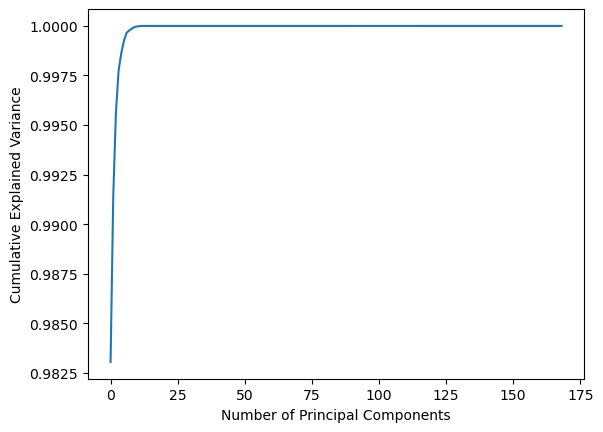

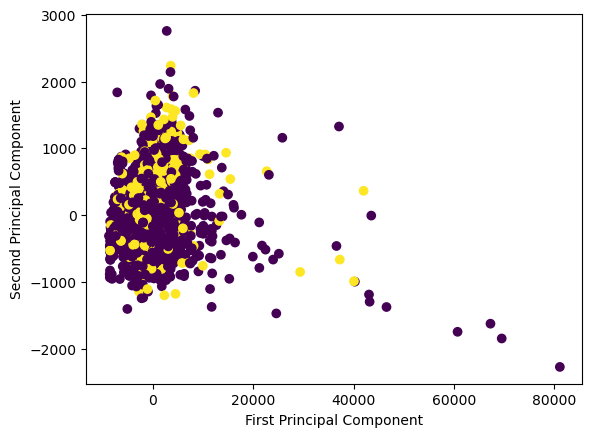

The most important 50 features are:
['Lot_Area', 'Gr_Liv_Area', 'First_Flr_SF', 'Garage_Area', 'Mas_Vnr_Area', 'Bsmt_Unf_SF', 'Wood_Deck_SF', 'Open_Porch_SF', 'Lot_Frontage', 'Screen_Porch', 'Enclosed_Porch', 'Year_Built', 'Year_Remod_Add', 'TotRms_AbvGrd', 'MS_SubClass_other_0', 'MS_SubClass_other_1', 'Bldg_Type_other_1', 'Bldg_Type_other_0', 'Fireplaces_0', 'MS_Zoning_Residential_Medium_Density_0', 'MS_Zoning_Residential_Medium_Density_1', 'Bsmt_Exposure_No_0', 'Bsmt_Exposure_No_1', 'Garage_Type_Detchd_1', 'Garage_Type_Detchd_0', 'Bsmt_Exposure_other_0', 'Bsmt_Exposure_other_1', 'Fireplaces_2', 'Lot_Shape_Slightly_Irregular_0', 'Lot_Shape_Slightly_Irregular_1', 'Bedroom_AbvGr_2', 'Full_Bath_1', 'Lot_Config_Inside_0', 'Lot_Config_Inside_1', 'Roof_Style_Hip_0', 'Roof_Style_Hip_1', 'Lot_Config_other_0', 'Lot_Config_other_1', 'Bedroom_AbvGr_4', 'Lot_Shape_other_1', 'Lot_Shape_other_0', 'Full_Bath_2', 'Bsmt_Full_Bath_0', 'Fireplace_Qu_Typical_1', 'Fireplace_Qu_Typical_0', 'Kitchen_Qual_Ty

In [19]:


X = df.iloc[:, :-1]
y = df.iloc[:, -1]

pca = PCA()
pca.fit(X)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

n = 50
X_reduced = pca.transform(X)[:, :n]

plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

features = X.columns
importances = np.abs(pca.components_[0])
indices = np.argsort(importances)[::-1]
most_important_features = [features[i] for i in indices[:n]]
print("The most important 50 features are:")
print(most_important_features)


# Testing

# Linear model with PCA

In [20]:
X = df_train.iloc[:, :99]
y = df_train.iloc[:, 99]

# perform PCA analysis
pca = PCA(n_components=None)
X_pca = pca.fit_transform(X)

# get the explained variance ratio of the components
explained_variance = pca.explained_variance_ratio_

# select the best features
selector = SelectKBest(f_regression, k=63)
X_best = selector.fit_transform(X_pca, y)

# fit the linear regression model
reg = LinearRegression()
reg.fit(X_best, y)

# check the R^2 score
print('R^2 score:', reg.score(X_best, y))

R^2 score: 0.8902015921885531


In [21]:
from xgboost import XGBRegressor

X = df.iloc[:,:-1]
y = df.iloc[:,-1]

pca = PCA(n_components=None)
X_pca = pca.fit_transform(X)
selector = SelectKBest(f_regression, k=50)
X_best = selector.fit_transform(X_pca, y)

xgb = XGBRegressor()
xgb.fit(X_best, y)
X2 = df_test.iloc[:,:]
X2_pca = pca.transform(X2)
X2_best = selector.transform(X2_pca)

y_pred = xgb.predict(X2_best)
result = np.exp(pd.Series(y_pred, name='Sale_Price'))

result.to_csv('prediction_result.csv', index=False)

ValueError: X has 170 features, but PCA is expecting 169 features as input.

# check for overfitting

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

zs = []
rmses = []
for zz in range(5,50,2):
    X = df.iloc[:,:-1]
    y = df.iloc[:,-1]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    pca = PCA(n_components=None)
    X_train_pca = pca.fit_transform(X_train)

    selector = SelectKBest(f_regression, k=zz)
    X_train_best = selector.fit_transform(X_train_pca, y_train)

    xgb = XGBRegressor()
    xgb.fit(X_train_best, y_train)

    X_test_pca = pca.transform(X_test)
    X_test_best = selector.transform(X_test_pca)

    y_pred = xgb.predict(X_test_best)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    zs.append(zz)
    rmses.append(mse)

ValueError: Found input variables with inconsistent numbers of samples: [410, 876]

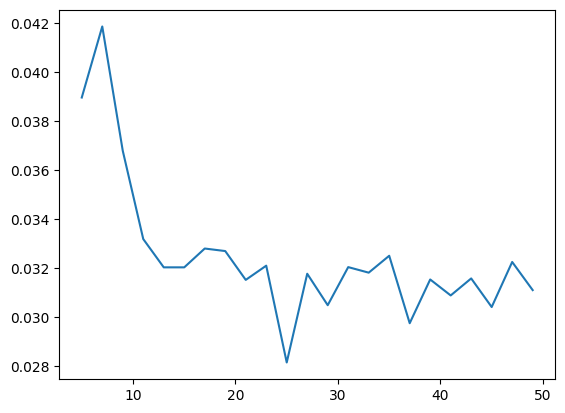

In [ ]:
plt.plot(zs,rmses)
plt.show()

In [ ]:
zs = []
rmses = []
for zz in range(1,100):
    X = df.iloc[:,:-1]
    y = df.iloc[:,-1]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    pca = PCA(n_components=None)
    X_train_pca = pca.fit_transform(X_train)

    selector = SelectKBest(f_regression, k=150)
    X_train_best = selector.fit_transform(X_train_pca, y_train)

    lasso = Lasso(alpha=zz/100000)
    lasso.fit(X_train_best, y_train)

    X_test_pca = pca.transform(X_test)

    X_test_best = selector.transform(X_test_pca)

    y_pred = lasso.predict(X_test_best)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    zs.append(zz)
    rmses.append(mse)

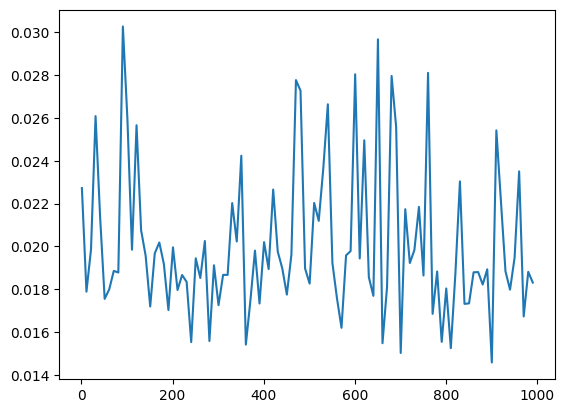

In [ ]:
plt.plot(zs,rmses)
plt.show()

In [ ]:

zs = []
rmses = []

# separate the features and target
X_train = df.iloc[:,:-1]
y_train = df.iloc[:,-1]

# perform PCA analysis on the training data
pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(X_train)

# select the best features from the training data
selector = SelectKBest(f_regression, k=150)
X_train_best = selector.fit_transform(X_train_pca, y_train)

# fit the Lasso model on the training data
lasso = Lasso(alpha=20/10000)
lasso.fit(X_train_best, y_train)

X_test = df_test

# perform PCA analysis on the test data
X_test_pca = pca.transform(X_test)

# select the best features from the test data
X_test_best = selector.transform(X_test_pca)

# use the fitted Lasso model to predict the 'Sale_Price' on the test data
y_pred = lasso.predict(X_test_best)

# return the prediction result in a pandas Series
result = np.exp(pd.Series(y_pred, name='Sale_Price'))

# write the result to a CSV file
result.index = result.index+1
result.index.rename("Id", inplace=True)
result.to_csv('prediction_result.csv', index=True)

# #######

# # separate the features and target
# X = df.iloc[:,:-1]
# y = df.iloc[:,-1]

# # perform PCA analysis
# pca = PCA(n_components=None)
# X_pca = pca.fit_transform(X)

# # select the best features
# selector = SelectKBest(f_regression, k=50)
# X_best = selector.fit_transform(X_pca, y)

# # fit the XGBoost model
# xgb = XGBRegressor()
# xgb.fit(X_best, y)

# # separate the features
# X2 = df_test.iloc[:,:]

# # perform PCA analysis on the second dataframe
# X2_pca = pca.transform(X2)

# # select the best features from the second dataframe
# X2_best = selector.transform(X2_pca)

# # use the fitted XGBoost model to predict the 'Sale_Price'
# y_pred = xgb.predict(X2_best)

# # return the prediction result in a pandas Series
# result = np.exp(pd.Series(y_pred, name='Sale_Price'))

# # write the result to a CSV file
# result.to_csv('prediction_result.csv', index=False)

In [ ]:
50/100000

0.0005

In [ ]:
result.index.rename("Id", inplace=True)





# Try Neural Net

In [ ]:
zs = []
rmses = []
for zz in range(10):
    X = df.iloc[:,:-1]
    y = df.iloc[:,-1]

    # Split the data into 80% train and 20% test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # perform PCA analysis on the training data
    pca = PCA(n_components=None)
    X_train_pca = pca.fit_transform(X_train)

    # select the best features from the training data
    selector = SelectKBest(f_regression, k=150)
    X_train_best = selector.fit_transform(X_train_pca, y_train)

    # fit the Neural Network model on the training data
    mlp = MLPRegressor(hidden_layer_sizes=(10,10,10), max_iter=5000)
    mlp.fit(X_train_best, y_train)

    # perform PCA analysis on the test data
    X_test_pca = pca.transform(X_test)

    # select the best features from the test data
    X_test_best = selector.transform(X_test_pca)

    # use the fitted Neural Network model to predict the 'Sale_Price' on the test data
    y_pred = mlp.predict(X_test_best)

    # evaluate the performance of the model using mean squared error and R-squared
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    zs.append(zz)
    rmses.append(mse)


0
1
2
3
4
5
6
7
8
9


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
rmses

[8.396078782172639,
 30.466984316046346,
 5.111552257790672,
 4.633457712405477,
 25.131027761973844,
 9.189288460430454,
 50.95057867711666,
 9.086933433610888,
 4.582678562462646,
 5.98245211958608]

# Try Ridge

In [22]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

zs = []
rmses = []
for zz in range(1,1000):
    if zz%100 == 0:
        print(zz)
    # separate the features and target
    X = df.iloc[:,:-1]
    y = df.iloc[:,-1]

    # Split the data into 80% train and 20% test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # fit the Ridge Regression model on the training data
    ridge = Ridge(alpha=zz/10)
    ridge.fit(X_train, y_train)

    # use the fitted Ridge Regression model to predict the 'Sale_Price' on the test data
    y_pred = ridge.predict(X_test)

    # evaluate the performance of the model using mean squared error and R-squared
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
#     print(f"Number of features: {zz:.4f}")
    zs.append(zz)
#     print(f"Mean Squared Error: {mse:.4f}")
    rmses.append(mse)
#     print(f"R-squared: {r2:.4f}")


100
200
300
400
500
600
700
800
900


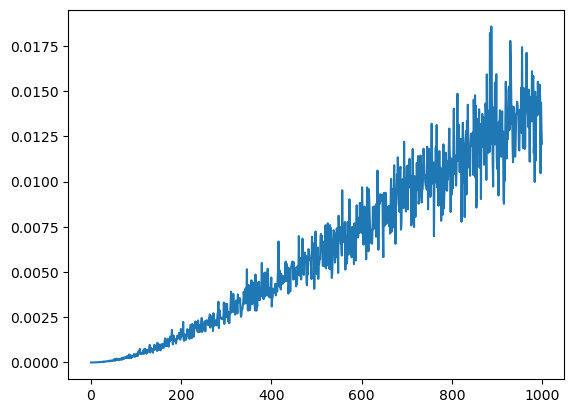

In [23]:
plt.plot(zs,rmses)
plt.show()

In [25]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

zs = []
rmses = []

# separate the features and target
X_train = df.iloc[:,:-1]
y_train = df.iloc[:,-1]

ridge = Ridge(alpha=75/10)
ridge.fit(X_train, y_train)

X_test = df_test

# use the fitted Ridge Regression model to predict the 'Sale_Price' on the test data
y_pred = ridge.predict(X_test)

# return the prediction result in a pandas Series
result = np.exp(pd.Series(y_pred, name='Sale_Price'))

# write the result to a CSV file
result.index = result.index+1
result.index.rename("Id", inplace=True)
result.to_csv('prediction_result.csv', index=True)


ValueError: X has 170 features, but Ridge is expecting 169 features as input.

# Random Forest

In [ ]:
zs = []
rmses = []
for zz in range(1,5):
    # separate the features and target
    X = df.iloc[:,:-1]
    y = df.iloc[:,-1]

    # Split the data into 80% train and 20% test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # fit the random forest model on the training data
    rf = RandomForestRegressor(n_estimators=zz*5)
    rf.fit(X_train, y_train)

    # use the fitted random forest model to predict the 'Sale_Price' on the test data
    y_pred = rf.predict(X_test)

    # evaluate the performance of the model using mean squared error and R-squared
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
#     print(f"Number of features: {zz:.4f}")
    zs.append(zz)
#     print(f"Mean Squared Error: {mse:.4f}")
    rmses.append(mse)
#     print(f"R-squared: {r2:.4f}")


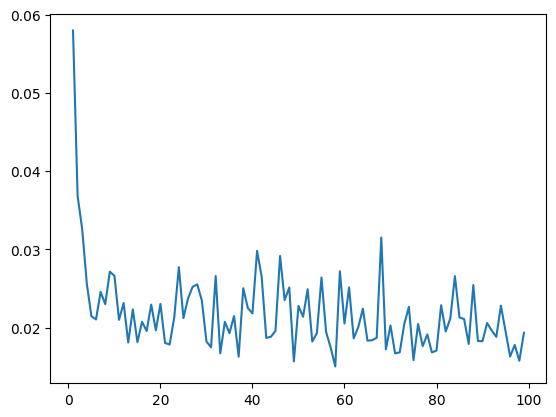

In [ ]:
plt.plot(zs,rmses)
plt.show()

In [ ]:
zs = []
rmses = []

# separate the features and target
X_train = df.iloc[:,:-1]
y_train = df.iloc[:,-1]

# fit the random forest model on the training data
rf = RandomForestRegressor(n_estimators=25)
rf.fit(X_train, y_train)

X_test = df_test

# use the fitted Ridge Regression model to predict the 'Sale_Price' on the test data
y_pred = rf.predict(X_test)

# return the prediction result in a pandas Series
result = np.exp(pd.Series(y_pred, name='Sale_Price'))

# write the result to a CSV file
result.index = result.index+1
result.index.rename("Id", inplace=True)
result.to_csv('prediction_result.csv', index=True)

# Gradient Boosting

In [ ]:
zs = []
rmses = []
for zz in range(1,100):
    X = df.iloc[:,:-1]
    y = df.iloc[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    gb = GradientBoostingRegressor(n_estimators=zz)
    gb.fit(X_train, y_train)

    y_pred = gb.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    zs.append(zz)
    rmses.append(mse)


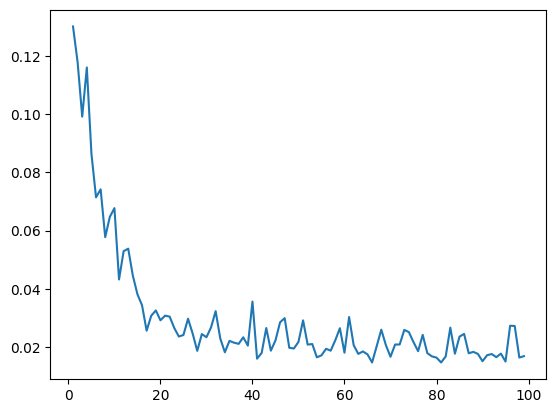

In [ ]:
plt.plot(zs,rmses)
plt.show()

In [ ]:
# separate the features and target
X_train = df.iloc[:,:-1]
y_train = df.iloc[:,-1]

# fit the gradient boosting model on the training data
gb = GradientBoostingRegressor(n_estimators=40)
gb.fit(X_train, y_train)

X_test = df_test

# use the fitted gradient boosting model to predict the 'Sale_Price' on the test data
y_pred = gb.predict(X_test)

# return the prediction result in a pandas Series
result = np.exp(pd.Series(y_pred, name='Sale_Price'))

# write the result to a CSV file
result.index = result.index+1
result.index.rename("Id", inplace=True)
result.to_csv('prediction_result.csv', index=True)
